# Обзор данных и попытка классифицировать треки

В этом ноутбуке я смотрю на данные и их особенности. 

## Импорт необходимых библиотек

In [1]:
# импорты из стандартной библиотеки
import re
import warnings

# импорты сторонних библиотек
import pandas as pd
import numpy as np

# импорт библиотек текущего модуля
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# настройки
warnings.filterwarnings("ignore")

# константы заглавными буквами
RANDOM_STATE = 12345

## Объявление функций

Объявим функции, необходимые для работы

In [2]:
def get_info(data: pd.DataFrame):
    """get_info()

    Аргумент:
        data (pd.DataFrame): Получает на вход pd.DataFrame

    Возвращает:
        Первые 5 строк датафрейма, метод .info() и метод .describe(include="all")
    """
    print("-" * 35 + "SAMPLE" + "-" * 35)
    display(data.head())
    print()
    print("-" * 36 + "INFO" + "-" * 36)
    print()
    display(data.info())
    print("-" * 34 + "DESCRIBE" + "-" * 34)
    display(data.describe(include="all"))


def leave_one_genre(data):
    """leave_one_genre()

    Аргументы:
        data (pd.Series): Получает на вход pd.Series с листами жанров

    Возвращает:
        pd.Series: Возвращает pd.Series с но вместо list теперь простая строка с одним жанром
    """
    return str(data[:1])

## Обзор данных

In [3]:
covers = pd.read_json("../data/covers.json", lines=True)
lyrics = pd.read_json("../data/lyrics.json", lines=True)
meta = pd.read_json("../data/meta.json", lines=True)


### Файл `covers`

In [4]:
get_info(covers)

-----------------------------------SAMPLE-----------------------------------


,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER



------------------------------------INFO------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


None

----------------------------------DESCRIBE----------------------------------


,original_track_id,track_id,track_remake_type
count,4821,71597,71597
unique,4468,71597,2
top,f3e5e9db509f9b6f6d93b9c38e4e1324,6e3f67ce4c33c1c9f3bf674f94ede804,COVER
freq,38,1,67304


### Файл `lyrics`

In [5]:
get_info(lyrics)

-----------------------------------SAMPLE-----------------------------------


,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659



------------------------------------INFO------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


None

----------------------------------DESCRIBE----------------------------------


,lyricId,text,track_id
count,11414,11414,11414
unique,10915,10644,10277
top,6fe05ce48761f833737487cd7a499cd3,Twenty-five years and my life is still\nI'm tr...,b891000882f4a612190142861b5c038b
freq,9,15,24


### Файл `meta`

In [6]:
get_info(meta)

-----------------------------------SAMPLE-----------------------------------


,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0



------------------------------------INFO------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


None

----------------------------------DESCRIBE----------------------------------


,track_id,dttm,title,language,isrc,genres,duration
count,71768,7.176800e+04,71768,21969,71455,71768,7.176800e+04
unique,71768,NaN,45462,85,71283,232,NaN
top,6e3f67ce4c33c1c9f3bf674f94ede804,NaN,Morena,EN,USTCF1017794,"[FOLK, LATINFOLK]",NaN
freq,1,NaN,81,15322,3,18391,NaN
mean,NaN,1.584287e+12,NaN,NaN,NaN,NaN,2.049187e+05
std,NaN,9.113923e+10,NaN,NaN,NaN,NaN,8.559854e+04
min,NaN,1.249926e+12,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,1.570141e+12,NaN,NaN,NaN,NaN,1.613700e+05
50%,NaN,1.620405e+12,NaN,NaN,NaN,NaN,1.993950e+05
75%,NaN,1.637050e+12,NaN,NaN,NaN,NaN,2.390700e+05


Все эти файлы объединяет признак `track_id`, замутим ***left join*** (т.к. не все данные имеются) по этому признаку в таком порядке:  
  
meta -> lyrics -> covers

In [7]:
merged_data = meta.merge(lyrics, how="left", on="track_id")
merged_data = merged_data.merge(covers, how="left", on="track_id")


### Объединенные данные

In [8]:
get_info(merged_data)

-----------------------------------SAMPLE-----------------------------------


,track_id,dttm,title,language,isrc,genres,duration,lyricId,text,original_track_id,track_remake_type
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0,36777cce0740d1e3d37a5a221c71d859,No more champagne\nAnd the fireworks are throu...,None,COVER
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0,8284927611c6a6fc49ff1ce7b3a88314,"Ooh-ooh, ooh, ooh\n\nEvery time you come aroun...",None,COVER
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0,NaN,NaN,None,COVER
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0,NaN,NaN,None,COVER
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0,NaN,NaN,None,COVER



------------------------------------INFO------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72906 entries, 0 to 72905
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           72905 non-null  object 
 1   dttm               72905 non-null  float64
 2   title              72905 non-null  object 
 3   language           22870 non-null  object 
 4   isrc               72566 non-null  object 
 5   genres             72905 non-null  object 
 6   duration           72905 non-null  float64
 7   lyricId            11414 non-null  object 
 8   text               11414 non-null  object 
 9   original_track_id  5378 non-null   object 
 10  track_remake_type  72571 non-null  object 
dtypes: float64(2), object(9)
memory usage: 6.7+ MB


None

----------------------------------DESCRIBE----------------------------------


,track_id,dttm,title,language,isrc,genres,duration,lyricId,text,original_track_id,track_remake_type
count,72905,7.290500e+04,72905,22870,72566,72905,7.290500e+04,11414,11414,5378,72571
unique,71768,NaN,45462,85,71283,232,NaN,10915,10644,4468,2
top,b891000882f4a612190142861b5c038b,NaN,Morena,EN,US4BR0500030,"[FOLK, LATINFOLK]",NaN,6fe05ce48761f833737487cd7a499cd3,Twenty-five years and my life is still\nI'm tr...,f3e5e9db509f9b6f6d93b9c38e4e1324,COVER
freq,24,NaN,81,16121,24,18399,NaN,9,15,41,67770
mean,NaN,1.582337e+12,NaN,NaN,NaN,NaN,2.051841e+05,NaN,NaN,NaN,NaN
std,NaN,9.291748e+10,NaN,NaN,NaN,NaN,8.537061e+04,NaN,NaN,NaN,NaN
min,NaN,1.249926e+12,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
25%,NaN,1.564349e+12,NaN,NaN,NaN,NaN,1.616300e+05,NaN,NaN,NaN,NaN
50%,NaN,1.620078e+12,NaN,NaN,NaN,NaN,1.996500e+05,NaN,NaN,NaN,NaN
75%,NaN,1.636756e+12,NaN,NaN,NaN,NaN,2.392800e+05,NaN,NaN,NaN,NaN


In [9]:
# очень странная строчка))
merged_data[merged_data["duration"].isna()]


,track_id,dttm,title,language,isrc,genres,duration,lyricId,text,original_track_id,track_remake_type
44796,None,NaN,None,None,None,None,NaN,NaN,NaN,NaN,NaN


Сразу удалим дату для изежания утечки данных

In [10]:
# дропнем дату и эту строку с пропусками
merged_data = merged_data.drop("dttm", axis=1)
merged_data = merged_data.drop(44796, axis=0)


In [11]:
# приведем столбец duration к типу int
merged_data["duration"] = merged_data["duration"].astype("int")


## Предобработка

In [12]:
merged_data["track_remake_type"].value_counts()


COVER       67770
ORIGINAL     4801
Name: track_remake_type, dtype: int64

Как и ожидалось, присутствует серьезный дисбаланс классов. Так получилось потому что оригиналов куда меньше чем каверов на них, все соответствует действительности.

Для начала не будем трогать текст. Удалим столбцы с большим количеством пропусков и посмотрим как отреагирует на это модель.

In [13]:
# удалим столбцы, в которых больше половины пропусков
prepared_dt = merged_data.dropna(thresh=merged_data.shape[0] / 2, axis=1)
prepared_dt = prepared_dt.drop("track_id", axis=1)


In [14]:
# удалим остальные пропуски
prepared_dt = prepared_dt[~prepared_dt["isrc"].isna()]
prepared_dt = prepared_dt[~prepared_dt["track_remake_type"].isna()]


In [15]:
# оставим только один жанр, а не лист
prepared_dt["genres"] = prepared_dt["genres"].apply(leave_one_genre)


In [16]:
cat_features = ["title", "isrc", "genres"]

for feature in cat_features:
    prepared_dt[feature] = prepared_dt[feature].astype("category")


In [17]:
prepared_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72242 entries, 0 to 72905
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   title              72242 non-null  category
 1   isrc               72242 non-null  category
 2   genres             72242 non-null  category
 3   duration           72242 non-null  int32   
 4   track_remake_type  72242 non-null  object  
dtypes: category(3), int32(1), object(1)
memory usage: 5.9+ MB


## Модель на метаданных

### Результаты на валидационной выборке

In [18]:
# Обозначим признак и таргет
X = prepared_dt.drop("track_remake_type", axis=1)
y = prepared_dt["track_remake_type"]

# делим на трейн и тест, сохраним отношение классов stratify=y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE
)

# отделяем также и валидационную выборку
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    stratify=y_train,
    test_size=0.25,
    random_state=RANDOM_STATE,
)

In [19]:
print(f"X.shape: {X.shape}, y.shape: {y.shape}")
print("-" * 50)
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


X.shape: (72242, 4), y.shape: (72242,)
--------------------------------------------------
X_train.shape: (43344, 4), y_train.shape: (43344,)
X_val.shape: (14449, 4), y_val.shape: (14449,)
X_test.shape: (14449, 4), y_test.shape: (14449,)


In [20]:
%%time


lgbm_model = LGBMClassifier(class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)

lgbm_model.fit(
    X_train, y_train, 
    categorical_feature=cat_features,
    eval_set=(X_val, y_val), 
    eval_metric='roc_auc'
)

y_pred = lgbm_model.predict(X_val)
y_pred_proba = lgbm_model.predict_proba(X_val)
acc_score = accuracy_score(y_val, y_pred)
roc_score = roc_auc_score(y_val, y_pred_proba[:,1])

print(f'ACCURACY: {acc_score:.2f}')
print(f' ROC AUC: {roc_score:.2f}')

[1]	valid_0's binary_logloss: 0.638396
[2]	valid_0's binary_logloss: 0.593356
[3]	valid_0's binary_logloss: 0.556346
[4]	valid_0's binary_logloss: 0.525305
[5]	valid_0's binary_logloss: 0.49887
[6]	valid_0's binary_logloss: 0.476312
[7]	valid_0's binary_logloss: 0.457112
[8]	valid_0's binary_logloss: 0.440426
[9]	valid_0's binary_logloss: 0.42605
[10]	valid_0's binary_logloss: 0.413516
[11]	valid_0's binary_logloss: 0.40246
[12]	valid_0's binary_logloss: 0.392908
[13]	valid_0's binary_logloss: 0.384551
[14]	valid_0's binary_logloss: 0.377084
[15]	valid_0's binary_logloss: 0.370527
[16]	valid_0's binary_logloss: 0.364785
[17]	valid_0's binary_logloss: 0.359387
[18]	valid_0's binary_logloss: 0.354636
[19]	valid_0's binary_logloss: 0.35078
[20]	valid_0's binary_logloss: 0.347161
[21]	valid_0's binary_logloss: 0.34401
[22]	valid_0's binary_logloss: 0.340659
[23]	valid_0's binary_logloss: 0.337736
[24]	valid_0's binary_logloss: 0.335185
[25]	valid_0's binary_logloss: 0.3331
[26]	valid_0's b

In [21]:
# Получим важности признаков
feature_importance = lgbm_model.feature_importances_

# Создаём DataFrame с названиями признаков и их важностями
balanced_importance_df = pd.DataFrame(
    {"feature": X_train.columns, "importance": feature_importance}
)

# Сортируем результаты
balanced_importance_df.sort_values("importance", ascending=False)


,feature,importance
3,duration,2016
2,genres,558
0,title,400
1,isrc,26


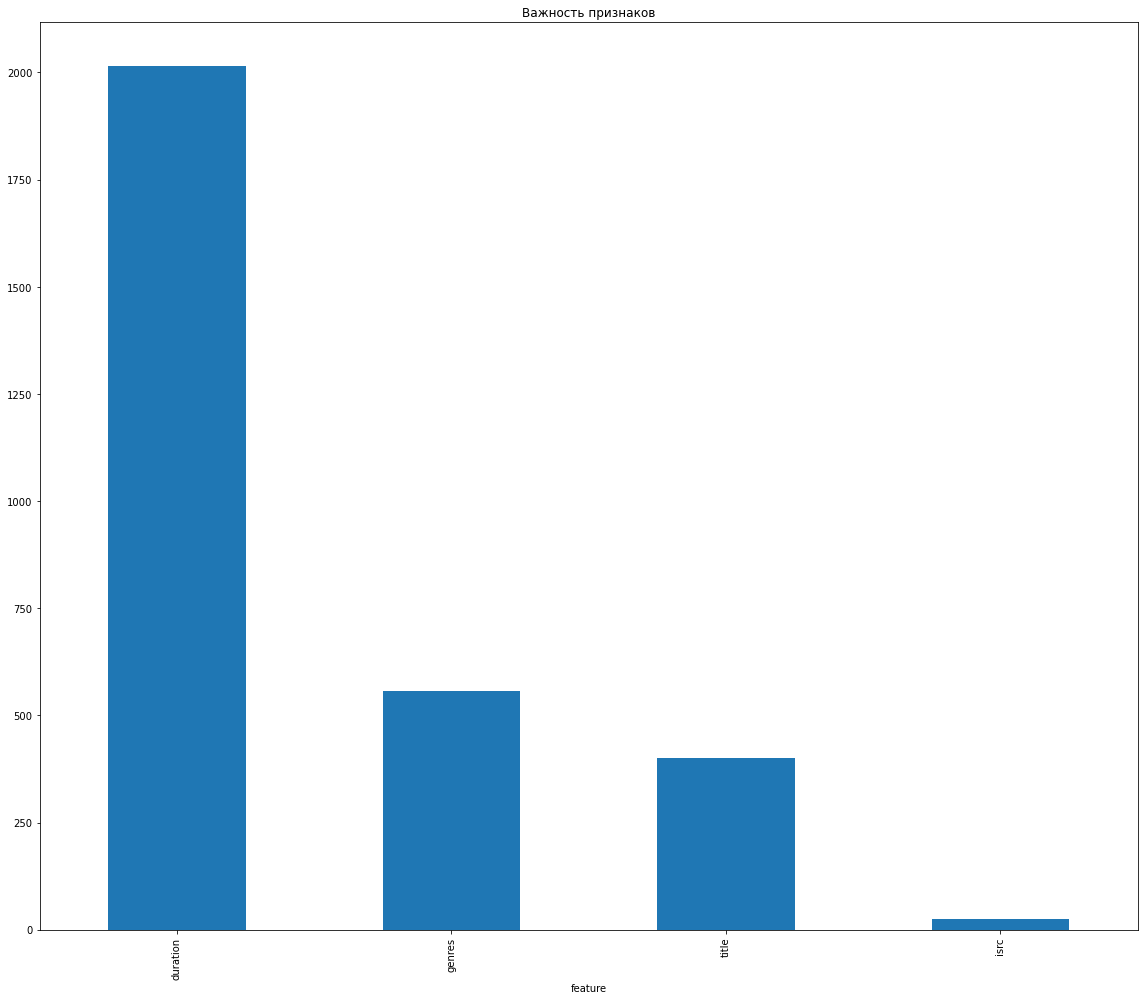

In [22]:
lgbm_imp = pd.Series(feature_importance, balanced_importance_df["feature"])

fig, ax = plt.subplots(figsize=(16, 14))
lgbm_imp.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()


In [23]:
# Получение матрицы ошибок
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

# Создание pd.DataFrame для матрицы ошибок
data = {"Прогноз (+)": [tp, fp], "Прогноз (-)": [fn, tn]}
index = ["Реальность (+)", "Реальность (-)"]
conf_matrix = pd.DataFrame(data=data, index=index)

# Вывод матрицы ошибок
print(conf_matrix)

                Прогноз (+)  Прогноз (-)
Реальность (+)          790          149
Реальность (-)         1954        11556


### Проверка на тестовой выборке

In [24]:
%%time

y_pred_test = lgbm_model.predict(X_test)
y_pred_proba_test = lgbm_model.predict_proba(X_test)
acc_score = accuracy_score(y_test, y_pred_test)
roc_score = roc_auc_score(y_test, y_pred_proba_test[:,1])

print(f'ACCURACY: {acc_score:.2f}')
print(f' ROC AUC: {roc_score:.2f}')

ACCURACY: 0.85
 ROC AUC: 0.93
Wall time: 885 ms


In [25]:
# Получение матрицы ошибок
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

# Создание pd.DataFrame для матрицы ошибок
data = {"Прогноз (+)": [tp, fp], "Прогноз (-)": [fn, tn]}
index = ["Реальность (+)", "Реальность (-)"]
conf_matrix = pd.DataFrame(data=data, index=index)

# Вывод матрицы ошибок
print(conf_matrix)

                Прогноз (+)  Прогноз (-)
Реальность (+)          800          139
Реальность (-)         2033        11477


## TF-IDF